# Z3 solver

Here we define a Z3 solver, with a 3d (= 2d + time) grid of t_cells, representing the current board state and previous timesteps for the required delta to be solved.

As we are going backwards, we can ignore the rules for dead cells, and simply define the constraints required for the past timestep to produce living cells in the current timestep. We also define a rule to ignore any cells that currently have 0 neighbours to reduce the search space and prevent zero-point energy solutions.

NOTE: With Z3 using boolean datatypes is 2-4x faster than using integer constraints

In [1]:
# TODO: add z3-solver to kaggle-docker image
! python3 -m pip install -q z3-solver
! apt-get install -qq tree moreutils

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libio-pty-perl.
(Reading database ... 109831 files and directories currently installed.)
Preparing to unpack .../libio-pty-perl_1%3a1.08-1.1build4_amd64.deb ...
Unpacking libio-pty-perl (1:1.08-1.1build4) ...
Selecting previously unselected package libipc-run-perl.
Preparing to unpack .../libipc-run-perl_0.96-1_all.deb ...
Unpacking libipc-run-perl (0.96-1) ...
Selecting previously unselected package moreutils.
Preparing to unpack .../moreutils_0.60-1_amd64.deb ...
Unpacking moreutils (0.60-1) ...
Selecting previously unselected package tree.
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Setting up libio-pty-perl (1:1.08-1.1build4) ...
Setting up libipc-run-perl (0.96-1) ...
Setting up moreutils (0.60-1) ...


In [2]:
# Download git repository and copy to local directory
!rm -rf /ai-games/
!git clone https://github.com/JamesMcGuigan/ai-games/ /ai-games/
# !cd /ai-games/; git checkout ad2f8cc94865f1be6083ca699d4b62b0cc039435
!cp -rf /ai-games/puzzles/game_of_life/* ./   # copy code to kaggle notebook
!rm -rf /kaggle/working/neural_networks/      # not relevant to this notebook
!cd /ai-games/; git log -n1 

Cloning into '/ai-games'...
remote: Enumerating objects: 7783, done.
remote: Counting objects: 100% (901/901), done.
remote: Compressing objects: 100% (499/499), done.
remote: Total 7783 (delta 629), reused 646 (delta 389), pack-reused 6882
Receiving objects: 100% (7783/7783), 200.99 MiB | 30.13 MiB/s, done.
Resolving deltas: 100% (5234/5234), done.
commit eac436d23e03624c2245838138e9608cb13d2f1f (HEAD -> master, origin/master, origin/HEAD)
Author: JamesMcGuigan <james.mcguigan.github@gmail.com>
Date:   Mon Feb 1 23:03:45 2021 +0000

    Revert: Rock Paper Scissors | Random Seed Search | tweak unit tests


Show the new filesystem contents of the notebook

In [3]:
! pwd
! tree -F

/kaggle/working
.
├── README.md
├── __init__.py
├── __notebook__.ipynb
├── ant_colony/
│   └── ant_colony.py
├── constraint_satisfaction/
│   ├── __init__.py
│   ├── fix_submission.py*
│   ├── solve_dataframe.py
│   ├── z3_constraints.py
│   ├── z3_costs.py
│   ├── z3_solver.ipynb
│   ├── z3_solver.py
│   ├── z3_solver.run.py*
│   ├── z3_solver.test.py
│   ├── z3_solver_patterns.py
│   └── z3_utils.py
├── download_dataset.sh*
├── game_of_life.iml
├── hashmaps/
│   ├── count_geometric_duplicates.py
│   ├── crop.py
│   ├── hash_functions.py
│   ├── hashmap_dataframe.py
│   ├── hashmap_solver.py
│   ├── primes.py
│   ├── primes_z3.log
│   ├── primes_z3.py*
│   ├── repeating_patterns.py
│   ├── reverse_patterns.py
│   ├── reverse_patterns_cache.py*
│   └── translation_solver.py
├── image_segmentation/
│   ├── clusters.py
│   ├── history_lookup.py
│   ├── history_lookup_cache.py
│   ├── image_segmentation_solver.py
│   └── tessellation.py
├── output/
│   ├── cluster_history_lookup.pickle
│ 

# Dataset Reimport Loop

There are 10 forks of this notebook running in parallel as a poor man's version of cluster compute using a modulo loop to subdivide the data, with the `submission.csv` file acting as a filesystem cache. They each reimport the output of each other, with the accumilated results of multiple 9-hour commit sessions merged together. 

Even still, this is a massive compute job and its going to take a while to finish all 50,000 entries in the test dataset given that each notebook can only compute a few hundred entries per commit cycle.

We also import any boards solved via the Hashmap Solver, which identifies geometric duplicates discovered from the training dataset, and generated data using forward play 
- https://www.kaggle.com/jamesmcguigan/game-of-life-hashmap-solver/

In [4]:
# Merge submission files from various sources into a single file. Reverse sort puts non-zero entries first, then use awk to deduplicate on id
!find ./ ../input/ /ai-games/puzzles/game_of_life/ -name 'submission.csv' | xargs cat | sort -nr | uniq | awk -F',' '!a[$1]++' | sort -n > ./submission_previous.csv
!find ./ ../input/ /ai-games/puzzles/game_of_life/ -name 'submission.csv' | xargs cat | sort -nr | uniq | awk -F',' '!a[$1]++' | sort -n > ./submission.csv
!find ./ ../input/ /ai-games/puzzles/game_of_life/ -name 'timeouts.csv'   | xargs cat | sort -nr | uniq | awk -F',' '!a[$1]++' | sort -n > ./timeouts.csv

# Count number of non-zero entries in each submission.csv file
!( for FILE in $(find ./ ../input/ /ai-games/puzzles/game_of_life/ -name '*submission.csv' | sort ); do cat $FILE | grep ',1' | wc -l | tr '\n' ' '; echo $FILE; done) | sort -n;

# BUGFIX: previous version of the code was computing to delta=-1, so replay submission.csv forward one step if required and validate we have the correct delta
# This also generates stats
!PYTHONPATH='.' python3 ./constraint_satisfaction/fix_submission.py

0 ../input/conways-reverse-game-of-life-2020/sample_submission.csv
28446 ./output/submission.csv
28446 ./submission.csv
28446 /ai-games/puzzles/game_of_life/output/submission.csv
fix_submission() wrote: ././/submission.csv
fix_submission() {'time': '19.6', 'empty': 21554, 'total': 50000, 'valid': 28446, 'fixed': 0, 'invalid': 0}


# Codebase

Full codebase can be seen either in the output files section of the notebook or on my github repo:
- https://github.com/JamesMcGuigan/ai-games/tree/master/puzzles/game_of_life

In [5]:
%load_ext autoreload
%autoreload 2

import itertools
import time
import numpy as np
import pandas as pd
import pydash
from typing import Union, List, Tuple
import os
import sys
from pathos.multiprocessing import ProcessPool

from utils.plot import *
from utils.game import *
from utils.util import *
from utils.datasets import *
from utils.display_source import *

print('os.cpu_count()', os.cpu_count())
notebook_start = time.perf_counter()

os.cpu_count() 4


In [6]:
# These imports won't work inside Kaggle Submit without an internet connection to install Z3
import z3
from constraint_satisfaction.z3_solver import *
from constraint_satisfaction.solve_dataframe import *

This is the main codebase implementing the Z3 SAT Solver.

- using Boolean rather than Integer logic results in a 2-4x speedup in solve times. 
- adding an additional constraint that any dead cell with zero neighbours should also be considered dead in the T=-1 timeframe dramatially reduces the state search space and prevents zero-point energy solutions (cells that are born and die in the vaccume of whitespace)

In [7]:
display_source('./constraint_satisfaction/z3_solver.py')

import time

import numpy as np
import z3

from constraint_satisfaction.fix_submission import is_valid_solution
from constraint_satisfaction.z3_constraints import get_exclude_solution_constraint, get_game_of_life_ruleset, \
    get_initial_board_constraint, get_no_empty_boards_constraint, \
    get_t_cells, get_zero_point_constraint
from constraint_satisfaction.z3_costs import get_initial_board_accuracy
from constraint_satisfaction.z3_utils import solver_score, solver_to_numpy_3d


def game_of_life_solver(board: np.ndarray, delta: int, idx: int, timeout=0, exact=True, verbose=True):
    time_start = time.perf_counter()

    z3_solver = z3.Optimize()
    t_cells   = get_t_cells( delta=delta, size=board.shape )
    z3_solver.add( get_no_empty_boards_constraint(t_cells) )
    z3_solver.add( get_game_of_life_ruleset(t_cells) )
    if exact:
        z3_solver.add( get_initial_board_constraint(t_cells, board) )
    else:
        z3_solver.maximize(get_initial_board_accuracy(t_cells, board))
    z3_solver.push()

    # This is a safety catch to prevent timeouts when running in Kaggle notebooks
    if timeout: z3_solver.set("timeout", int(timeout * 1000/2.5))  # timeout is in milliseconds, but inexact and ~2.5x slow

    ### Adding optimization constraints can make everything really slow!
    # z3_solver.minimize( get_surface_area(t_cells, distance=2) )
    # z3_solver.minimize( get_lone_cell_count(t_cells) )
    # z3_solver.maximize( get_whitespace_area(t_cells) )
    # z3_solver.maximize( get_static_pattern_score(t_cells) )

    # cluster_history_lookup.pickle file is now now 9.3Mb zipped
    z3_result = None
    for constraint in [
        # lambda: get_static_board_constraint(t_cells, board),                      # should be quick to evaluate
        # lambda: get_repeating_board_constraint(t_cells, board, frequency=2),      # should be quick to evaluate
        # lambda: get_image_segmentation_solver_constraint(t_cells, board, delta),  # makes debugger slow + causes Kaggle memory issues
        # lambda: get_image_segmentation_csv(t_cells, idx),       # uses less memory than solver
        lambda: z3.And([]),                                       # included in get_image_segmentation_solver_constraint()
    ]:
        constraint = constraint()
        if not isinstance(constraint, z3.AstRef) and len(constraint) == 0: continue  # ignore empty constraints
        z3_solver.push()
        z3_solver.add( constraint )

        # BUGFIX: zero_point_distance=1 breaks test_df[90081]
        # NOTE:   zero_point_distance=2 results in: 2*delta slowdown
        # NOTE:   zero_point_distance=3 results in another 2-6x slowdown (but in rare cases can be quicker)
        # noinspection PyAssignmentToLoopOrWithParameter
        for constraint in [
            lambda: get_zero_point_constraint(t_cells, zero_point_distance=1),
            lambda: get_zero_point_constraint(t_cells, zero_point_distance=2),
        ]:
            z3_solver.push()
            z3_solver.add( constraint() )
            z3_result = z3_solver.check()   # can return z3.unknown when exact = False
            is_sat    = z3_result == z3.sat # or (not exact and z3_result == z3.unknown)  # z3.unknown == Fail
            if is_sat: break            # found a solution - skip zero_point_distance=2
            else:      z3_solver.pop()  # remove zero_point_constraints
        if is_sat: break                # found a solution - use it
        else:      z3_solver.pop()      # remove get_image_segmentation_solution()


    # Validate that forward play matches backwards solution
    solution_3d = solver_to_numpy_3d(z3_solver, t_cells, z3_result=z3_result)  # calls z3_solver.check()
    time_taken  = time.perf_counter() - time_start
    if np.count_nonzero(solution_3d[0]):  # quicker than calling z3_solver.check() again
        assert not exact or is_valid_solution(solution_3d[0], board, delta)
        score = solver_score( solution_3d, board, delta=delta )
        if verbose: print(

In [8]:
display_source('./constraint_satisfaction/z3_constraints.py')

import itertools

import numpy as np
import pydash
import z3

from constraint_satisfaction.z3_utils import get_neighbourhood_cells
from image_segmentation.image_segmentation_solver import image_segmentation_solver  # expensive filesystem import
from utils.game import life_step_3d
from utils.util import csv_to_numpy


def get_t_cells(delta=1, size=(25,25)):
    t_cells = [
        [
            [ z3.Bool(f"({x:02d},{y:02d})@t={t}") for y in range(size[1]) ]
            for x in range(size[0])
        ]
        for t in range(0, delta+1)
    ]
    return t_cells



def get_game_of_life_ruleset(t_cells, delta=0):
    # Create a 25x25 board for each timestep we need to solve for
    # T=0 for start_time, T=delta-1 for stop_time
    size_x, size_y = len(t_cells[0]), len(t_cells[0][0])
    delta = delta or len(t_cells)-1

    # Rules expressed forwards:
    # living + 4-8 neighbours = dies
    # living + 2-3 neighbours = lives
    # living + 0-1 neighbour  = dies
    # dead   +   3 neighbours = lives
    constraints = []
    for t in range(len(t_cells)-delta, len(t_cells)):
        for x,y in itertools.product(range(size_x), range(size_y)):
            cell            = t_cells[t][x][y]
            past_cell       = t_cells[t-1][x][y]
            past_neighbours = get_neighbourhood_cells(t_cells[t-1], x, y)  # excludes self
            constraints.append(
                # dead   + 3 neighbours   = lives
                # living + 2-3 neighbours = lives
                cell == z3.And([
                    z3.AtLeast( past_cell, *past_neighbours, 3 ),
                    z3.AtMost(             *past_neighbours, 3 ),
                ])
            )
    return constraints



def get_no_empty_boards_constraint(t_cells):
    """ Add constraint that there can be no empty boards """
    constraints = []
    for t in range(0, len(t_cells)-1):
        layer = pydash.flatten_deep(t_cells[t])
        constraints.append( z3.AtLeast( *layer, 3 ) )  # Three is a minimum viable board
    return constraints



def get_zero_point_constraint(t_cells, zero_point_distance: int, delta=0):
    # Ignore any currently dead cell with 0 neighbours,
    # This considerably reduces the state space and prevents zero-point energy solutions
    # BUGFIX: distance=1 breaks test_df[90081]
    size_x, size_y = ( len(t_cells[0]), len(t_cells[0][0]) )
    delta = delta or len(t_cells)-1
    constraints = []
    for t in range(len(t_cells)-delta, len(t_cells)):
        for x,y in itertools.product(range(size_x), range(size_y)):
            cell      = t_cells[t][x][y]
            past_cell = t_cells[t-1][x][y]
            if zero_point_distance:
                current_neighbours = get_neighbourhood_cells(t_cells[t], x, y, distance=zero_point_distance)
                constraints.append(
                    z3.If(
                        z3.AtMost( cell, *current_neighbours, 0 ),
                        past_cell == False,
                        True
                    )
                )
    return constraints



def get_initial_board_constraint(t_cells, board, delta=0):
    """ assert all( t_cells[-1] == board ) """
    constraints = [
        t_cells[-1-delta][x][y] == bool(board[x][y])
        for x,y in itertools.product(range(board.shape[0]), range(board.shape[1]))
    ]
    return constraints


def get_static_board_constraint(t_cells, board):
    constraints = [
        t_cells[t][x][y] == bool(board[x][y])
        for t in range(len(t_cells)-1)
        for x,y in itertools.product(range(board.shape[0]), range(board.shape[1]))
    ]
    return constraints


def get_repeating_board_constraint(t_cells, board, frequency=2):
    if frequency <= len(t_cells)-1: frequency = 1   # ensure we don't constrain to a blank board
    constraints = [
        t_cells[t][x][y] == bool(board[x][y])
        for t in range(len(t_cells)-1)
        for x,y in itertools.product(range(board.shape[0]), range(board.shape[1]))
        if len(t_cells)-t % frequency == 0
    ]
    return

This is the main multiprocessing loop for processing submission.csv

In [9]:
display_source('./constraint_satisfaction/solve_dataframe.py')

import os
import sys
import time
import traceback
from typing import Tuple

import humanize
import numpy as np
import pandas as pd
from humanize import precisedelta
from pathos.multiprocessing import ProcessPool

from constraint_satisfaction.fix_submission import is_valid_solution_3d
from constraint_satisfaction.z3_solver import game_of_life_solver
from constraint_satisfaction.z3_utils import solver_score
from utils.datasets import submission_file, test_df, timeout_file
from utils.idx_lookup import get_unsolved_idxs
from utils.plot import plot_3d, plot_idx
from utils.util import csv_to_delta, csv_to_numpy, numpy_to_dict


# Parallel(n_jobs=n_jobs)([ delayed(solve_board_deltaN)(board, delta, idx) ])
def solve_board_idx(board: np.ndarray, delta: int, idx: int, exact=True, timeout=0, verbose=True) -> Tuple[np.ndarray, int, float]:
    time_start = time.perf_counter()

    z3_solver, t_cells, solution_3d = game_of_life_solver(board, delta=delta, idx=idx, exact=exact, timeout=timeout, verbose=False)

    time_taken = time.perf_counter() - time_start
    if verbose:
        score = solver_score(solution_3d, board, delta)
        message = (
                 f"Solved! " if is_valid_solution_3d(solution_3d)
            else f"Partial " if np.count_nonzero(solution_3d[0])
            else f"unsolved"
        )
        print(f'{idx:05d} | delta = {delta} | cells = {np.count_nonzero(board):3d} -> {np.count_nonzero(solution_3d):3d} | {100*score:5.1f}% {message} {time_taken:6.1f}s')
    return solution_3d, idx, time_taken


def solve_board_delta1_loop(board: np.ndarray, delta: int, idx: int, exact=True, timeout=0, verbose=True) -> Tuple[np.ndarray, int, float]:
    """
    instead of trying to solve to delta=5 in one go, what if repeatedly try to solve for delta=1
    turns out this can be significantly faster than trying to solve to delta=N in one go
    """
    time_start = time.perf_counter()

    output = [ board ]
    for t in range(delta):
        z3_solver, t_cells, solution_3d = game_of_life_solver(board, delta=1, idx=idx, exact=exact, timeout=timeout, verbose=False)
        board = solution_3d[0]
        output.insert(0, board)
    solution_3d = np.array(output)

    time_taken = time.perf_counter() - time_start
    if verbose:
        score = solver_score(solution_3d, board, delta)
        message = (
                 f"Solved! " if is_valid_solution_3d(solution_3d)
            else f"Partial " if np.count_nonzero(solution_3d[0])
            else f"unsolved"
        )
        print(f'{idx:05d} | delta = {delta} | cells = {np.count_nonzero(board):3d} -> {np.count_nonzero(solution_3d):3d} | {100*score:5.1f}% {message} {time_taken:6.1f}s')
    return solution_3d, idx, time_taken


def solve_dataframe(
        df: pd.DataFrame = test_df,
        savefile=submission_file,
        timeout=0,
        max_timeout=4*60*60,
        max_count=0,
        max_cells=0,
        max_delta=5,
        sort_cells=True,
        sort_delta=True,
        exact=True,
        modulo=(1,0),
        plot=False,
        cpu_count=0,
) -> pd.DataFrame:
    if not os.path.exists(savefile):  open(savefile, 'a').close()
    time_start = time.perf_counter()

    # BUGFIX: game_of_life_solver() previously implemented delta+1, so fix any previous savefiles
    # fix_submission()  # DONE: remove once all datasets have been updated

    timeout_df    = pd.read_csv(timeout_file, index_col='id')
    submission_df = pd.read_csv(savefile,     index_col='id')  # manually copy/paste sample_submission.csv to location
    solved = 0
    total  = 0  # only count number solved in current runtime, ignore history

    # Pathos multiprocessing allows iterator semantics, whilst joblib has reduced CPU usage at the end of each batch
    # 75% CPU load to optimize for localhost CPU cache + solve memory leaks on Kaggle
    cpus = int( cpu_count or os.cpu_count() * (1 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') else 3/4) )
    pool = ProcessPool(ncpus=cpus)
    try:
        # # timeo

In [10]:
display_source('./utils/idx_lookup.py')

from typing import Any, Callable, List

import numpy as np
import pandas as pd

from utils.util import csv_to_numpy


def get_unsolved_idxs(df: pd.DataFrame, submission_df: pd.DataFrame, modulo=(1,0),
                      sort_cells=False, sort_delta=False, max_cells=0, max_delta=0) -> List[int]:
    """ Compare test_df with submission_df and return any idxs without a matching non-zero entry in submission_df """
    # Process in assumed order of difficulty, easiest first | smaller grids are easier, smaller deltas are easier
    if modulo:                    df = df[ df.index % modulo[0] == modulo[1] ]
    if max_cells:                 df = df[ df.apply(np.count_nonzero, axis=1) <= max_cells ]
    if max_delta:                 df = df[ df['delta'] <= max_delta ]

    if   sort_cells == 'random':  df = df.sample(frac=1)
    elif sort_cells == 'reverse': df = df.iloc[::-1]
    elif sort_cells:              df = df.iloc[ df.apply(np.count_nonzero, axis=1).argsort() ]
    if   sort_delta:              df = df.sort_values(by='delta', kind='mergesort')  # mergesort is stable sort

    idxs   = [
        idx
        for idx in df.index
        if np.count_nonzero( csv_to_numpy(submission_df, idx, key='start') ) == 0
    ]
    assert isinstance(idxs, list)  # BUGFIX: must return list (not generator), else invalid csv entries occur
    return list(idxs)



def get_invarient_idxs(
        start_df: pd.DataFrame,
        stop_df:  pd.DataFrame = None,
        hash_fn:  Callable[[np.ndarray], Any] = None,
        unique = False,
) -> List[int]:
    """
    Compare start_df with stop_df and return idxs for boards that did not change between deltas
    if hash_fn = callable(board) is provided, then this is hash function used to determine identity
    if start_df == train_df, we can reuse the same file with a single argument
    """
    assert callable(hash_fn) or hash_fn is None
    if hash_fn is None: hash_fn = lambda board: np.array(board, dtype=np.int8).tobytes()
    if stop_df is None: stop_df = start_df

    idxs           = sorted( set(start_df.index) & set(stop_df.index) )
    starts         = [ csv_to_numpy(start_df, idx, key='start') for idx in idxs ]
    stops          = [ csv_to_numpy(stop_df,  idx, key='stop')  for idx in idxs ]
    start_hashes   = [ hash_fn(start) for start in starts ]
    stop_hashes    = [ hash_fn(stop)  for stop  in stops  ]

    invarient_idxs = {
        (start_hash if unique else idx): idx
        for idx, start_hash, stop_hash in zip(idxs, start_hashes, stop_hashes)
        if start_hash == stop_hash
    }
    invarient_idxs = list(invarient_idxs.values())
    return invarient_idxs

This is the forward implemention of the game of life implemented 3 different ways, with profiler measurements
```
  42.7µs - lambda: [ life_step(x)    for x in dataset ],  # 2882.0µs without numba
 200.1µs - lambda: [ life_step_1(x)  for x in dataset ],
  38.7µs - lambda: [ life_step_2(x)  for x in dataset ],
```

In [11]:
display_source('./utils/game.py')

# Functions for implementing Game of Life Forward Play
from typing import List
from typing import Union

import numpy as np
import scipy.sparse
from joblib import delayed
from joblib import Parallel
from numba import njit


# Source: https://www.kaggle.com/ianmoone0617/reversing-conways-game-of-life-tutorial
def life_step_numpy(X: np.ndarray):
    """Game of life step using generator expressions"""
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (nbrs_count == 3) | (X & (nbrs_count == 2))


# Source: https://www.kaggle.com/ianmoone0617/reversing-conways-game-of-life-tutorial
def life_step_scipy(X: np.ndarray):
    """Game of life step using scipy tools"""
    from scipy.signal import convolve2d
    nbrs_count = convolve2d(X, np.ones((3, 3)), mode='same', boundary='wrap') - X
    return (nbrs_count == 3) | (X & (nbrs_count == 2))



# NOTE: @njit doesn't like np.roll(axis=) so reimplement explicitly
@njit
def life_neighbours_xy(board: np.ndarray, x, y, max_value=3):
    size_x = board.shape[0]
    size_y = board.shape[1]
    neighbours = 0
    for i in (-1, 0, 1):
        for j in (-1, 0, 1):
            if i == j == 0: continue    # ignore self
            xi = (x + i) % size_x
            yj = (y + j) % size_y
            neighbours += board[xi, yj]
            if neighbours > max_value:  # shortcircuit return 4 if overpopulated
                return neighbours
    return neighbours


@njit
def life_neighbours(board: np.ndarray, max_value=3):
    size_x = board.shape[0]
    size_y = board.shape[1]
    output = np.zeros(board.shape, dtype=np.int8)
    for x in range(size_x):
        for y in range(size_y):
            output[x,y] = life_neighbours_xy(board, x, y, max_value)
    return output


@njit
def life_step_njit(board: np.ndarray) -> np.ndarray:
    """Game of life step using generator expressions"""
    size_x = board.shape[0]
    size_y = board.shape[1]
    output = np.zeros(board.shape, dtype=np.int8)
    for x in range(size_x):
        for y in range(size_y):
            cell       = board[x,y]
            neighbours = life_neighbours_xy(board, x, y, max_value=3)
            if ( (cell == 0 and      neighbours == 3 )
              or (cell == 1 and 2 <= neighbours <= 3 )
            ):
                output[x, y] = 1
    return output

life_step = life_step_njit  # create global alias
def life_steps(boards: Union[List[np.ndarray],np.ndarray]) -> List[np.ndarray]:
    """ Parallel version of life_step() but for an array of boards """
    return Parallel(-1)( delayed(life_step)(board) for board in boards )


@njit
def life_step_delta(board: np.ndarray, delta):
    for t in range(delta): board = life_step(board)
    return board


def life_steps_delta(boards: np.ndarray, deltas: Union[np.ndarray,int]) -> np.ndarray:
    """ Parallel version of life_step() but for an array of boards """
    if isinstance(deltas, int): deltas = np.ones((len(boards),)) * deltas
    return np.array( Parallel(-1)( delayed(life_step_delta)(board, delta) for (board, delta) in zip(boards, deltas) ) )


def life_step_3d(board: np.ndarray, delta):
    solution_3d = np.array([ board ], dtype=np.int8)
    for t in range(delta):
        board       = life_step(board)
        solution_3d = np.append( solution_3d, [ board ], axis=0)
    return solution_3d


# RULES: https://www.kaggle.com/c/conway-s-reverse-game-of-life/data
def generate_random_board(shape=(25,25)):
    # An initial board was chosen by filling the board with a random density between 1% full (mostly zeros) and 99% full (mostly ones).
    # DOCS: https://cmdlinetips.com/2019/02/how-to-create-random-sparse-matrix-of-specific-density/
    density = np.random.random() * 0.98 + 0.01
    board   = scipy.sparse.random(*shape, density=density, data_rvs=np.ones).toarray().astype(np.int8)

    # The starting board's state was recorded after the 5 "warmup steps". These are th

Casting functions for converting between datatypes

In [12]:
display_source('./utils/util.py')

from typing import Dict

import numpy as np
import pandas as pd
from fastcache._lrucache import clru_cache


@clru_cache(None)
def csv_column_names(key='start'):
    return [ f'{key}_{n}' for n in range(25**2) ]


def csv_to_delta(df, idx):
    return int(df.loc[idx]['delta'])

def csv_to_delta_list(df):
    return df['delta'].values


def csv_to_numpy(df, idx, key='start') -> np.ndarray:
    try:
        columns = csv_column_names(key)
        board   = df.loc[idx][columns].values
    except:
        board = np.zeros((25, 25), dtype=np.int8)
    board = board.reshape((25,25))
    return board.astype(np.int8)


def csv_to_numpy_list(df, key='start') -> np.ndarray:
    try:
        columns = csv_column_names(key)
        output  = df[columns].values.reshape(-1,25,25)
    except:
        output  = np.zeros((0,25,25), dtype=np.int8)
    return output.astype(np.int8)


# noinspection PyTypeChecker,PyUnresolvedReferences
def numpy_to_dict(board: np.ndarray, key='start') -> Dict:
    assert len(board.shape) == 2  # we want 2D solutions_3d[0] not 3D solutions_3d
    assert key in { 'start', 'stop' }

    board  = np.array(board).flatten().tolist()
    output = { f"{key}_{n}": board[n] for n in range(len(board))}
    return output


def numpy_to_series(board: np.ndarray, key='start') -> pd.Series:
    solution_dict = numpy_to_dict(board, key)
    return pd.Series(solution_dict)


# Source: https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

This lets us plot out user-friendly visualiztions

In [13]:
display_source('./utils/plot.py')

import matplotlib.pyplot as plt
import numpy as np

from utils.util import csv_to_delta, csv_to_numpy


def plot_3d(solution_3d: np.ndarray, size=4, max_cols=6, title=''):
    cols = np.min([ len(solution_3d), max_cols ])
    rows = len(solution_3d) // cols + 1
    plt.figure(figsize=(cols*size, rows*size))
    plt.title(title)
    for t in range(len(solution_3d)):
        board = solution_3d[t]
        plt.subplot(rows, cols, t + 1)
        plt.imshow(board, cmap='binary'); plt.title(f't={t}')
    plt.show()


def plot_idx(df, idx: int, size=4):
    # pd.read_csv(index_col='id') implies offset of 1 (original code uses offset = 2)
    delta = csv_to_delta(df, idx)
    start = csv_to_numpy(df, idx, key='start')
    stop  = csv_to_numpy(df, idx, key='stop')
    if len(start) == 0: start = np.zeros(stop.shape)
    if len(stop)  == 0: start = np.zeros(start.shape)

    plt.figure(figsize=(size*2,size))
    plt.subplot(121)
    plt.imshow(start, cmap='binary'); plt.title(f'{idx}: start = T=0')
    plt.subplot(122)
    plt.imshow(stop,  cmap='binary'); plt.title(f'{idx}: stop = T={delta}')
    plt.show()

Deployment specific lookups for the dataset .csv files 

In [14]:
display_source('./utils/datasets.py')

# $ kaggle c download conways-reverse-game-of-life-2020
# $ unzip conways-reverse-game-of-life-2020.zip -d input

import os

import numpy as np
import pandas as pd

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    root_directory   = './'
    input_directory  = os.path.join(root_directory, '../input/conways-reverse-game-of-life-2020/')
    output_directory = os.path.join(root_directory, './')
else:
    root_directory   = os.path.join(os.path.dirname(__file__), '../')
    input_directory  = os.path.join(root_directory, './input/')
    output_directory = os.path.join(root_directory, './output/')


train_file              = f'{input_directory}/train.csv'
test_file               = f'{input_directory}/test.csv'
sample_submission_file  = f'{input_directory}/sample_submission.csv'
submission_file         = f'{output_directory}/submission.csv'
timeout_file            = f'{output_directory}/timeouts.csv'
image_segmentation_file = f'{root_directory}/output/image_segmentation_solutions.csv'

assert os.path.exists(train_file)
assert os.path.exists(test_file)
assert os.path.exists(sample_submission_file)


# Ensure the submission.csv file exists
def copy_sample_submission_file():
    if not os.path.exists(submission_file) or os.path.getsize(submission_file) == 0:
        if os.path.dirname(submission_file): os.makedirs(os.path.dirname(submission_file), exist_ok=True)
        with open(sample_submission_file, 'r') as source, open(submission_file, 'w') as dest:
            print(f'copy_sample_submission_file(): {submission_file} missing, copying from {sample_submission_file}')
            dest.write(source.read())
copy_sample_submission_file()


train_df              = pd.read_csv(train_file, index_col='id').astype(np.int)
test_df               = pd.read_csv(test_file,  index_col='id').astype(np.int)
submission_df         = pd.read_csv(submission_file,  index_col='id').astype(np.int)
sample_submission_df  = pd.read_csv(sample_submission_file,  index_col='id').astype(np.int)
timeout_df            = pd.read_csv(timeout_file,  index_col='id') if os.path.exists(timeout_file) else pd.DataFrame(columns=['id','timeout'])
image_segmentation_df = pd.read_csv(image_segmentation_file,  index_col='id').astype(np.int)


# Ensure submission.csv contains all required indices and is in sorted order
def copy_sample_submission_missing_indexes():
    global submission_df
    idxs          = set(sample_submission_df.index) - set(submission_df.index)
    if len(idxs):
        submission_df = pd.concat([ submission_df, sample_submission_df.loc[idxs] ])
        submission_df.sort_index().to_csv(submission_file)
        print(f'copy_sample_submission_missing_indexes(): copied {len(idxs)} missing indexes from {sample_submission_file} to {submission_file}')
copy_sample_submission_missing_indexes()

Test that all answers in the in the submission.csv file, when played forward, match the input data

In [15]:
display_source('./test/test_submission.py')

./test/test_submission.py

# Dataset

In [16]:
test_df

,delta,stop_0,stop_1,stop_2,stop_3,stop_4,stop_5,stop_6,stop_7,stop_8,...,stop_615,stop_616,stop_617,stop_618,stop_619,stop_620,stop_621,stop_622,stop_623,stop_624
id,,,,,,,,,,,,,,,,,,,,,
50000,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
50001,5,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
50002,1,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
50003,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
50004,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Range of Possible Solutions   

Here we show the first 10 solutions to the first (very simple) datapoint, having excluded most of the zero-point energy solutions (ie clusters of cells that appear and dissapear in the vaccume of whitespace).

To find the exact starting conditions used by kaggle, would require computing valid solutions to T=-5 to account for the warmup period, but this can be very slow.

Note how for even very simple starting conditions, there is a very large range of possible solutions

game_of_life_solver() - took:    4.4s | Solved! 100.0%


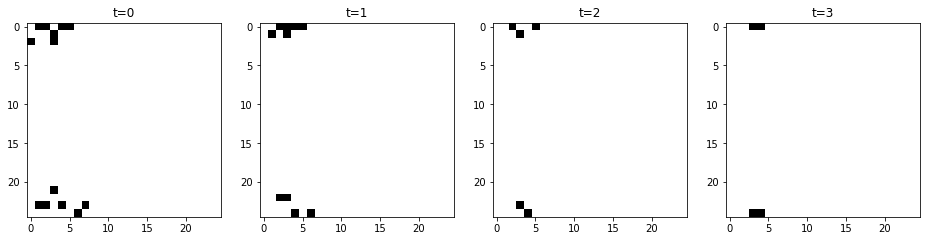

game_of_life_next_solution() - took: 0.6s


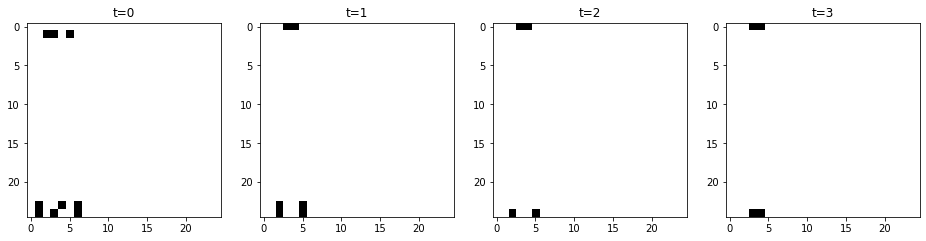

game_of_life_next_solution() - took: 0.6s


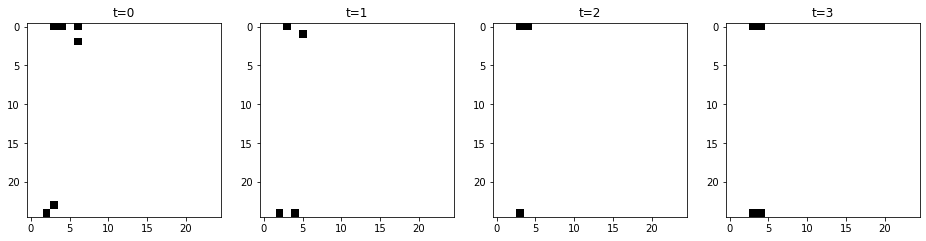

game_of_life_next_solution() - took: 0.5s


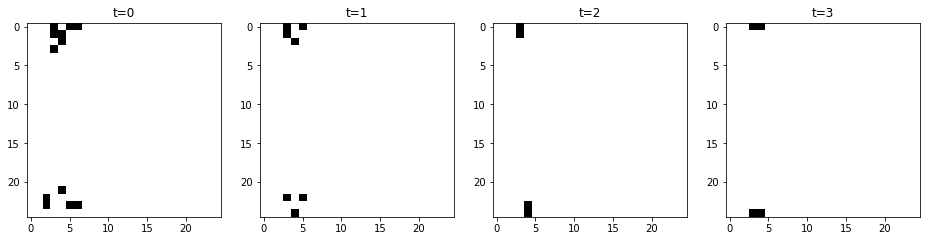

game_of_life_next_solution() - took: 0.5s


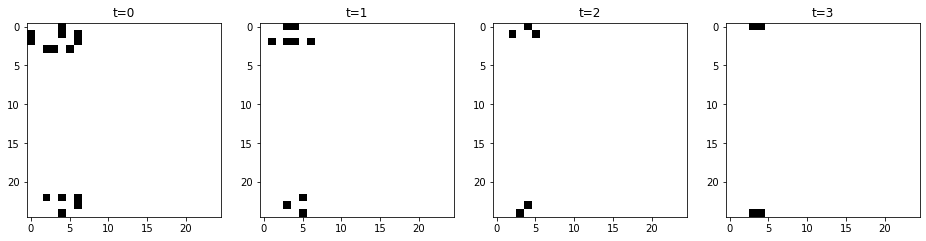

game_of_life_next_solution() - took: 0.5s


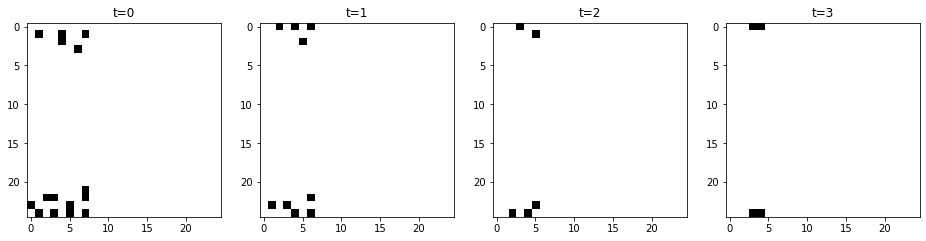

game_of_life_next_solution() - took: 0.5s


In [17]:
idx      = 0  
delta    = csv_to_delta(train_df, idx)
board    = csv_to_numpy(train_df, idx, key='stop')
expected = csv_to_numpy(train_df, idx, key='start')

time_start     = time.perf_counter()
solution_count = 0
z3_solver, t_cells, solution_3d = game_of_life_solver(board, delta, idx=idx)
while np.count_nonzero(solution_3d):
    solution_count += 1
    plot_3d(solution_3d)
    z3_solver, t_cells, solution_3d = game_of_life_next_solution(z3_solver, t_cells, verbose=True) # takes ~0.5s per solution
    if solution_count > 5: break
# print(f'Total Solutions: {solution_count} in {time.perf_counter() - time_start:.1f}s')  # too many to count

# Train Dataset

00000 | delta = 3 | cells =   9 ->  23 |  98.6% Solved!     4.0s


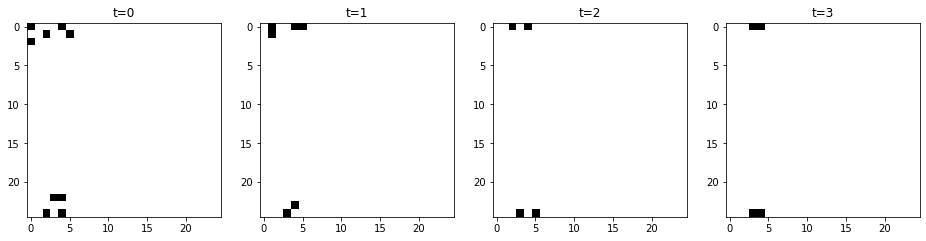

In [18]:
idx      = 0
delta    = csv_to_delta(train_df, idx)
board    = csv_to_numpy(train_df, idx, key='stop')
solution_3d, idx, time_taken = solve_board_delta1_loop(board, delta, idx)
plot_3d( solution_3d )

# Test Dataset

As we can see, large deltas are exponentially more difficult to solve than smaller deltas.

We can also use either joblib or pathos.multiprocessing to make full use of the 4 vCPU cores available in the Kaggle Kernel. 

The modulo paramter lets me split training between kaggle notebooks and localhost compute whilst retaining sorting (lets solve the easy ones first). 

# Submission

There are 50,000 data points in the test dataset, which divided by the 9 hour notebook timeout gives us a performance requirement of 0.6s to solve each datapoint.

For performance optimiztion, `solve_dataframe()` uses pathos.multiprocessing, uses submission.csv as a cache file and persists after each solution is found, avoiding recomputing non-zero entries already in the file. Kaggle provides us with upto 10 * 9 hour commit sessions at once. `modulo % 10 == N` is used to evenly divide the dataset between 10 forked copies of itself, that can all be run simultaneously as the poor man's version of cluster compute. The notebooks then all reimport each other's output files and the multiple .csv files are merged in bash using `find|xargs|sort|awk`

Even still, 50,000 entries is going to require a very large amount of compute, with notebooks being manually restarted every 9 hours. All I need to do is to [keep pushing the button](https://www.youtube.com/watch?v=xsksWR8uTDQ&ab_channel=busterroni11) without getting Lost.

In [19]:
notebook_time = (time.perf_counter() - notebook_start)
print(f'notebook_time = {notebook_time:.0f}s = {notebook_time/60:.1f}m')

notebook_time = 32s = 0.5m


71245 | delta = 1 | cells = 198 -> 460 | 100.0% Solved!    60.8s


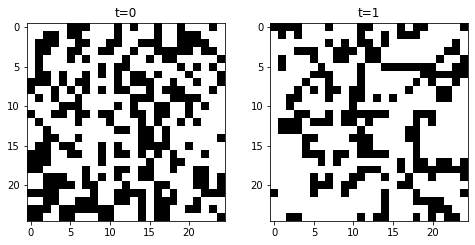

83665 | delta = 1 | cells = 187 -> 456 | 100.0% Solved!   130.2s


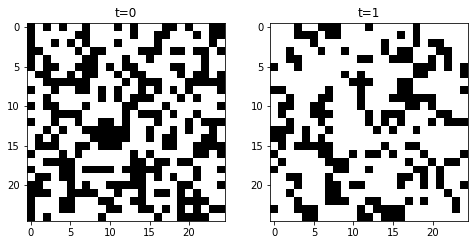

53155 | delta = 1 | cells = 194 -> 452 | 100.0% Solved!   165.1s


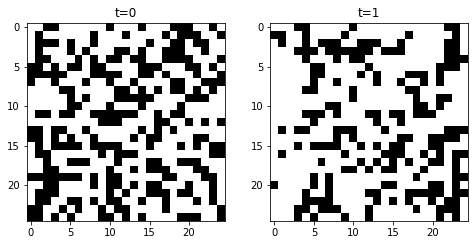

64324 | delta = 2 | cells =  95 -> 536 | 100.0% Solved!   399.5s


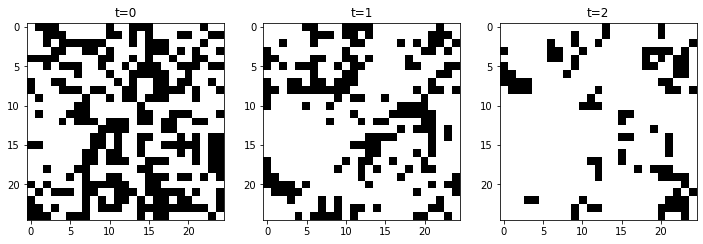

79147 | delta = 2 | cells =  99 -> 557 | 100.0% Solved!   576.1s


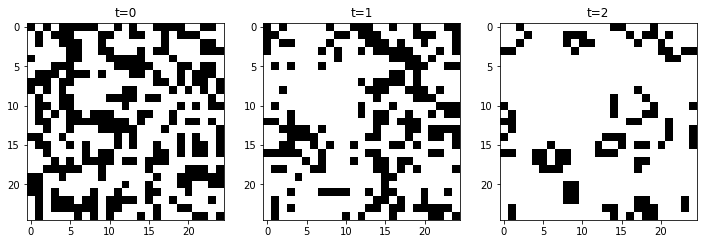

54442 | delta = 2 | cells = 132 -> 597 | 100.0% Solved!   956.0s


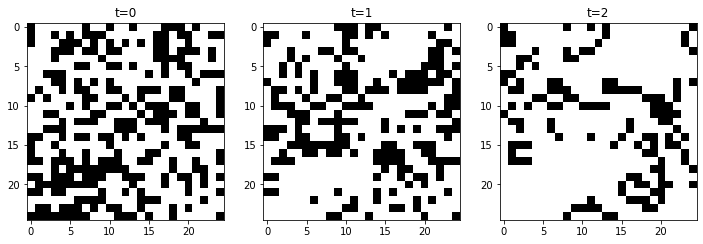

67969 | delta = 2 | cells = 146 -> 607 | 100.0% Solved!  1947.6s


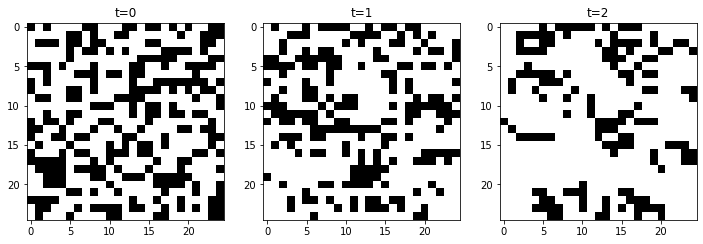

91387 | delta = 2 | cells = 151 -> 491 | 100.0% Solved!  1609.7s


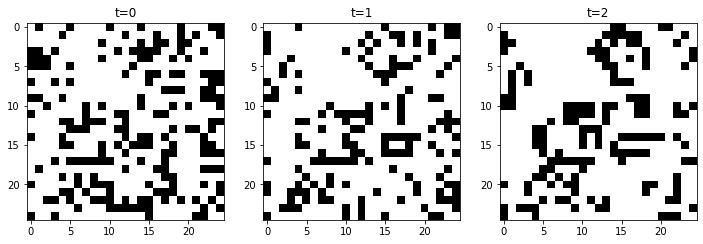

68122 | delta = 2 | cells = 153 -> 512 | 100.0% Solved!  2164.0s


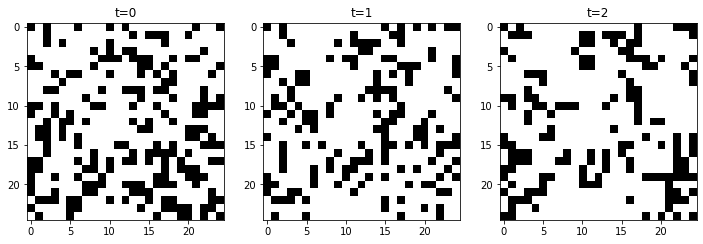

87463 | delta = 2 | cells = 151 -> 640 | 100.0% Solved!  3912.9s


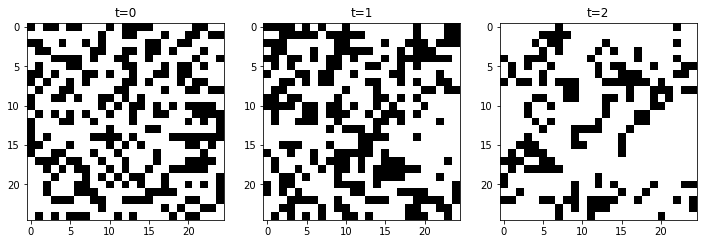

88552 | delta = 2 | cells = 153 -> 509 | 100.0% Solved!  1620.3s


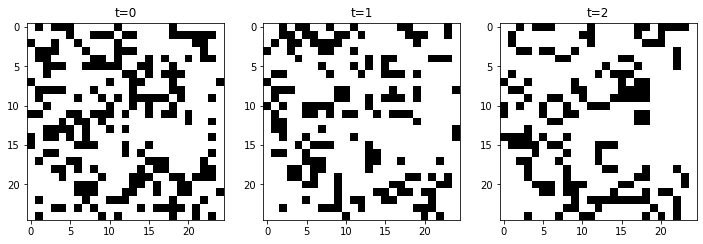

99487 | delta = 2 | cells = 153 -> 512 | 100.0% Solved!  3490.9s


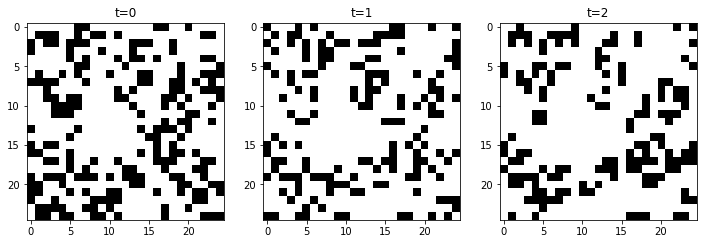

51625 | delta = 2 | cells = 154 -> 516 | 100.0% Solved!  3166.3s


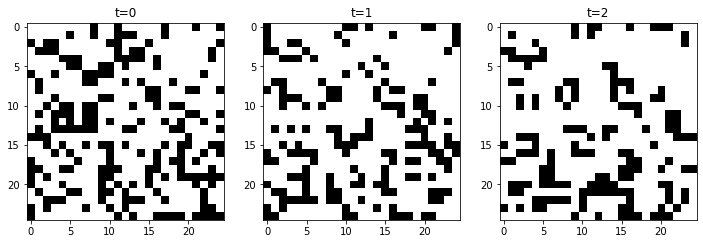

58852 | delta = 2 | cells = 154 -> 483 | 100.0% Solved!  1705.1s


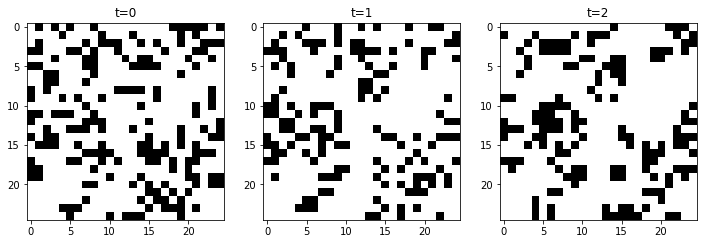

97624 | delta = 2 | cells = 154 -> 485 | 100.0% Solved!  1159.1s


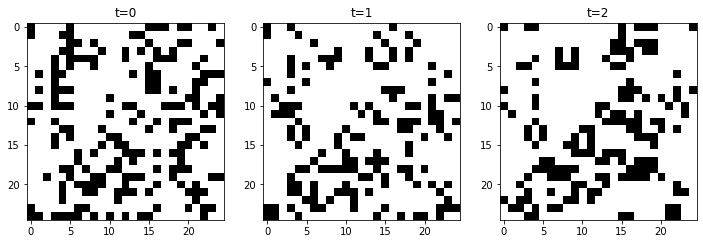

59374 | delta = 2 | cells = 145 ->   0 |  76.8% unsolved 11527.2s


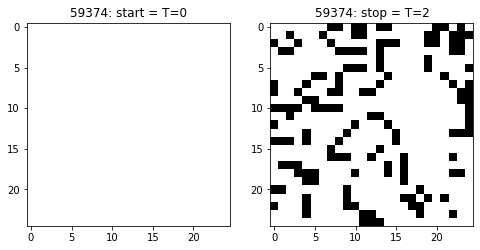

87508 | delta = 2 | cells = 155 -> 516 | 100.0% Solved!  1062.7s


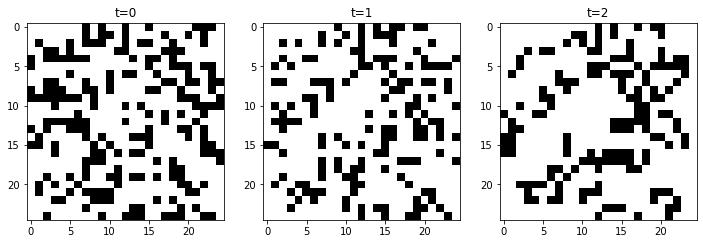

81055 | delta = 2 | cells = 155 -> 516 | 100.0% Solved!  1457.2s


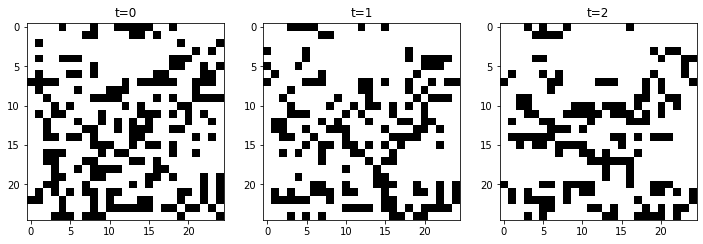

97255 | delta = 2 | cells = 155 -> 517 | 100.0% Solved!  1989.9s


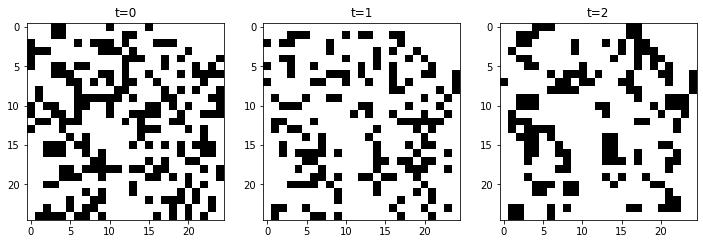

67672 | delta = 2 | cells = 153 ->   0 |  75.5% unsolved 11527.9s


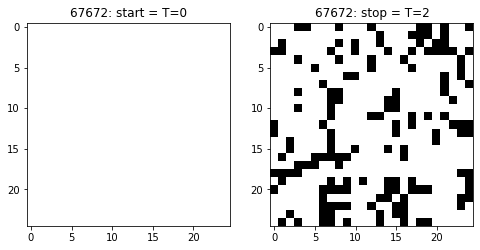

54136 | delta = 2 | cells = 155 -> 499 | 100.0% Solved!  1023.3s


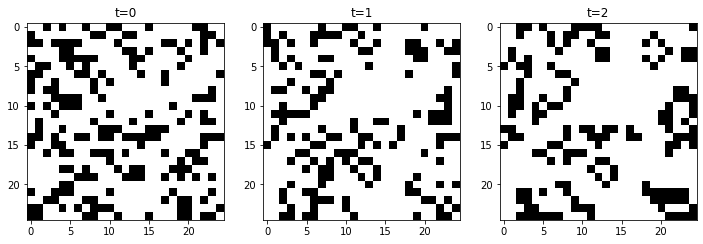

99397 | delta = 2 | cells = 155 -> 512 | 100.0% Solved!  2280.3s


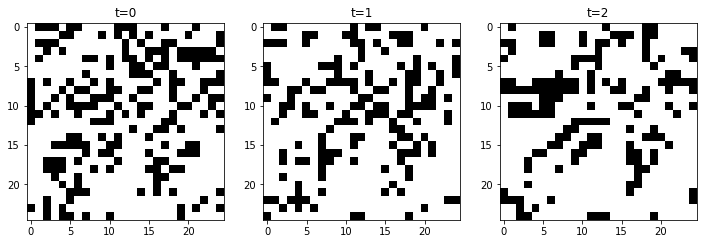

65089 | delta = 2 | cells = 155 -> 548 | 100.0% Solved!  2097.2s


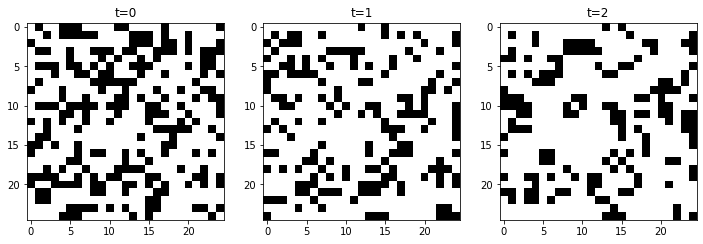

66889 | delta = 2 | cells = 155 -> 515 | 100.0% Solved!  3516.6s


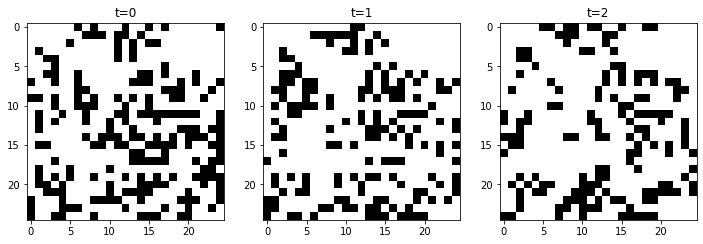

70372 | delta = 2 | cells = 155 -> 492 | 100.0% Solved!  1328.4s


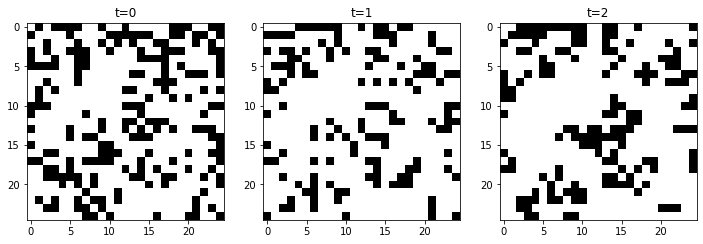

56053 | delta = 2 | cells = 155 -> 489 | 100.0% Solved!  1605.6s


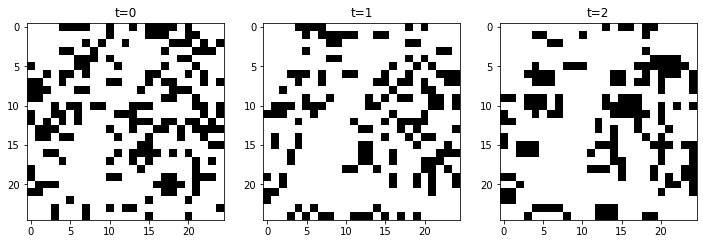

66295 | delta = 2 | cells = 156 -> 470 | 100.0% Solved!   630.7s


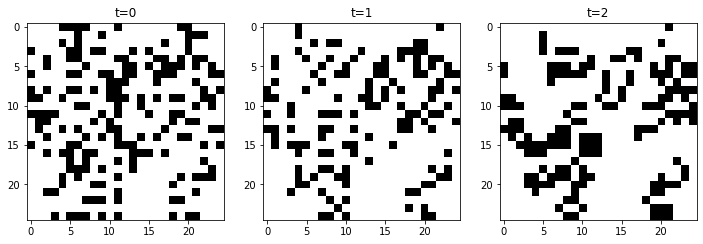

81280 | delta = 2 | cells = 156 -> 496 | 100.0% Solved!  3192.7s


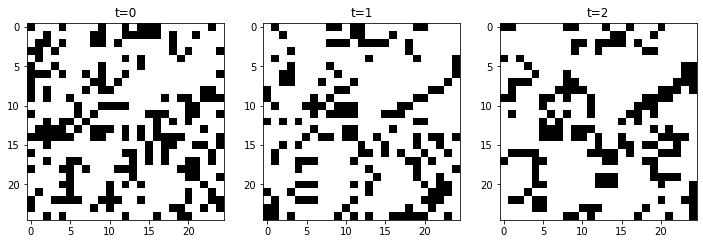

53668 | delta = 2 | cells = 154 ->   0 |  75.4% unsolved 11527.7s


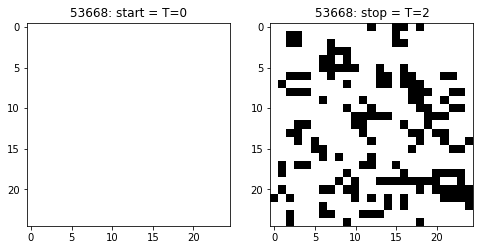

50203 | delta = 2 | cells = 156 -> 499 | 100.0% Solved!  2952.0s


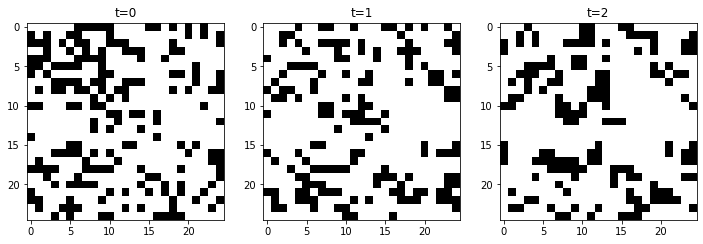

87490 | delta = 2 | cells = 156 -> 515 | 100.0% Solved!  4489.1s


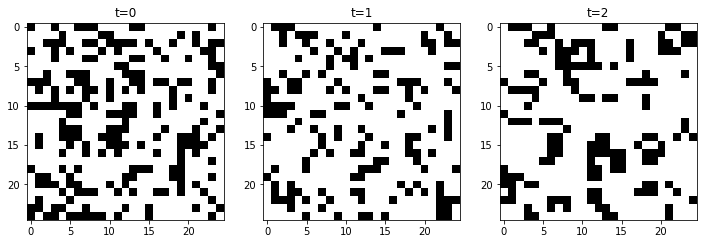

Solved: 28/31 = 90.3% in 6 hours


In [20]:
submission_df = solve_dataframe(test_df, savefile='submission.csv', timeout=(6*60*60 - notebook_time), modulo=(9,1), plot=True)
# submission_df = solve_dataframe(test_df, savefile='submission.csv', timeout=(0.1*60*60 - notebook_time), modulo=(9,1), plot=True)

In [21]:
# Cleanup python caches to prevent poluting kaggle notebook outputs
!find ./ -name '__pycache__' -or -name '*.py[cod]'  -delete

# Cluster Progress Counts

As a Count of [Sealand](https://en.wikipedia.org/wiki/Principality_of_Sealand), I do indeed [like to count](https://www.youtube.com/watch?v=ZIniljT5lJI), so this notbook has to end with a count of successfully solved games:

In [22]:
# BUGFIX: previous version of the code was computing to delta=-1, so replay submission.csv forward one step if required and validate we have the correct delta
# This also generates stats
!PYTHONPATH='.' python3 ./constraint_satisfaction/fix_submission.py

fix_submission() wrote: ././/submission.csv
fix_submission() {'time': '22.4', 'empty': 21526, 'total': 50000, 'valid': 28474, 'fixed': 0, 'invalid': 0}


In [23]:
# Count number of non-zero entries in each submission.csv file
!( for FILE in *.csv; do cat $FILE | grep ',1,' | wc -l | tr '\n' ' '; echo $FILE; done ) | sort -n;

0 timeouts.csv
28446 submission_previous.csv
28474 submission.csv
